In [1]:
#pip install matplotlib


In [2]:
import time 
import traceback
import mysql.connector
from mysql.connector import Error
from mysql.connector import pooling



DATABASE = 'nekretnine'
USERNAME = 'root'
PASSWORD = 'password'


class DatabaseManager:
    
    def __init__(self):
        self.connection_pool=None
        
    def createConnectionPool(self):
        self.connection_pool = pooling.MySQLConnectionPool(pool_name="pynative_pool",
                                                  pool_size=5,
                                                  pool_reset_session=True,
                                                  host='localhost',
                                                  database=DATABASE,
                                                  user=USERNAME,
                                                  password=PASSWORD)

        
    def executeSelectQuery(self, query):
        result=None
        try:
            connection = self.connection_pool.get_connection()
            cursor = connection.cursor()
            cursor.execute(query)
            result = cursor.fetchall()
            print('record gotten')
        except Error as e:
            print("Error while connecting to MySQL using Connection pool ", e)
        finally:
            # closing database connection.
            if connection.is_connected():
                cursor.close()
            connection.close()
            return result;
            
            

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

class DataVisualiser:
    def __init__(self):
        self.databaseManager = None
        
    def createDataFrame(self, turpleData, columnNames):
        df = pd.DataFrame(turpleData, columns = columnNames)
        return df
    
    def showMostFrequentBelgradeParts(self):        
        query = "select PART_OF_CITY, count(*) as COUNT_REAL_ESTATE from nekretnine.real_estate_t where city='Beograd' group by part_of_city order by count_real_estate desc limit 10;"
        
        result = self.databaseManager.executeSelectQuery(query)
        
        columnNames = ['PartOfTheCity', 'NumberOfRealEstates']
        dataFrame = self.createDataFrame(result, columnNames)
        
        plt.figure(figsize=(30, 10))
        plt.bar(dataFrame[columnNames[0]], dataFrame[columnNames[1]])
        plt.title('Delovi Beograda sa najviše nekretnina u ponudi', fontsize=35)
        plt.xlabel('Deo grada', fontsize=30)
        plt.ylabel('Broj nekretnina', fontsize=30)
        plt.xticks(fontsize=20,rotation=10)
        plt.yticks(fontsize=20)
        plt.grid(True)
        plt.show()
        
    def showNumOfAppartmentsPerSquareFootage(self):
        query = "select square_footage from nekretnine.real_estate_t where square_footage is not null and real_estate_type='S' and offer_type='P' order by square_footage asc;"
        
        result = self.databaseManager.executeSelectQuery(query)
        
        ranges = [35, 50, 65, 80, 95, 110, 641]
        columnNames = ['SquareFootage']
        dataFrame = self.createDataFrame(result, columnNames)
        dataFrame.hist(bins=ranges, figsize=(30, 15), xlabelsize=20, ylabelsize=20)
        plt.title('Broj stanova za prodaju po kvadraturi', fontsize=35)
        plt.ylabel('Broj stanova', fontsize=30)
        plt.xlabel('Kvadratura', fontsize=30)
        plt.show()
        
    def showNumOfRealEstatePerObjectType(self):
        query = "select object_type from nekretnine.real_estate_t order by object_type asc;"
        
        result = self.databaseManager.executeSelectQuery(query)
        
        columnNames = ['ObjectType']
        dataFrame = self.createDataFrame(result, columnNames)
        dataFrame.apply(lambda s: s.value_counts(dropna=False)).plot(kind='bar', fontsize=20, figsize=(30, 10))
        plt.legend(['Tip gradnje'], prop={'size':20})
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.ylabel('Broj stanova', fontsize=30)
        plt.xlabel('Tip gradnje', fontsize=30)
        plt.title('Broj stanova po tipu gradnje', fontsize=35)
        plt.show()
        
    def showOfferTypePercentageInCitiesWithMostOffers(self):
        query = "select city, offer_type from nekretnine.real_estate_t r1 inner join (select r2.city as c from nekretnine.real_estate_t r2 group by c order by count(*) desc limit 5) cities on r1.city=cities.c;"
        
        result = self.databaseManager.executeSelectQuery(query)
        
        columnNames = ['City', 'OfferType']
        dataFrame = self.createDataFrame(result, columnNames)
        bars = pd.crosstab(dataFrame['City'],dataFrame['OfferType']).plot.bar(fontsize=20, figsize=(30, 20))
        dataFrameLabels = pd.crosstab(dataFrame['City'],dataFrame['OfferType'], normalize='index')
        labels = [dataFrameLabels['I'][0], dataFrameLabels['P'][0], dataFrameLabels['I'][1], dataFrameLabels['P'][1], dataFrameLabels['I'][2], dataFrameLabels['P'][2], dataFrameLabels['I'][3], dataFrameLabels['P'][3],dataFrameLabels['I'][4], dataFrameLabels['P'][4]]
        i = 0
        for bar in bars.patches:
            value = "{:.2f}".format(labels[i] * 100)
            value = value + "%"
            text = f'{value}'
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_y() + bar.get_height() + 5
            bars.text(text_x, text_y, text, ha='center',color='black',size=20)
            i = i + 1
        plt.legend(['Izdavanje', 'Prodaja'], prop={'size':20}, title='Tip ponude', title_fontsize=25)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.xlabel('Grad', fontsize=30)
        plt.ylabel('Broj nekretnina', fontsize=30)
        plt.title('Broj stanova po tipu gradnje u gradovima sa najvise nekretnina', fontsize=35)
        plt.show()
        
    def showNumberOfRealEstateToSellInRange(self):
        query = "select price from nekretnine.real_estate_t where offer_type='P' order by price;"
        
        result = self.databaseManager.executeSelectQuery(query)
        
        columnNames = ['Price']
        dataFrame = self.createDataFrame(result, columnNames)
        
        binValues = [0, 49999, 99999, 149999, 199999, 5000000]
        labels = ['< 49999€', '[50000, 99999]€', '[100000, 149999]€', '[150000, 200000]€', '> 200000€']
        textAbove = dataFrame['Price'].value_counts(bins=binValues, sort=False, normalize=True).values
        dataValues = dataFrame['Price'].value_counts(bins=binValues, sort=False).values
        
        fig, ax = plt.subplots(figsize=(30, 20))        
        ax.bar(labels, dataValues)
        
        i = 0
        for bar in ax.patches:
            value = "{:.2f}".format(textAbove[i] * 100)
            value = value + "%"
            text = f'{value}'
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_y() + bar.get_height() + 5
            ax.text(text_x, text_y, text, ha='center',color='black',size=20)
            i = i + 1

        plt.subplot(ax)
        plt.title('Broj nekretnina u odredjenom cenovnom opsegu', fontsize=35)
        plt.xlabel('Cene', fontsize=30)
        plt.ylabel('Broj nekretnina', fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.grid(True)
        plt.show()
        
    def showRealEstatePerParking(self):
        query = "select parking from nekretnine.real_estate_t where offer_type='P' and city='Beograd' order by parking;"
        
        result = self.databaseManager.executeSelectQuery(query)
        columnNames = ['Parking']
        dataFrame = self.createDataFrame(result, columnNames)
        dataFrame.apply(lambda s: s.value_counts(dropna=False)).plot.bar(fontsize=20, figsize=(30, 20))
        plt.legend(['Parking'], prop={'size':20})
        plt.title('Nekretnine koje imaju parking', fontsize=35)
        plt.xlabel('Parking', fontsize=30)
        plt.ylabel('Broj nekretnina', fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.grid(True)
        plt.show()
        
        
    def plotTasks(self):
        self.databaseManager = DatabaseManager()
        self.databaseManager.createConnectionPool()
        
        print('First task')
        self.showMostFrequentBelgradeParts()
        
        print('Second task')
        self.showNumOfAppartmentsPerSquareFootage()
        
        print('Third task')
        self.showNumOfRealEstatePerObjectType()
        
        print('Fourth task')
        self.showOfferTypePercentageInCitiesWithMostOffers()
    
        print('Fifth task')
        self.showNumberOfRealEstateToSellInRange()
        
        print('Sixth task')
        self.showRealEstatePerParking()
    

First task
record gotten


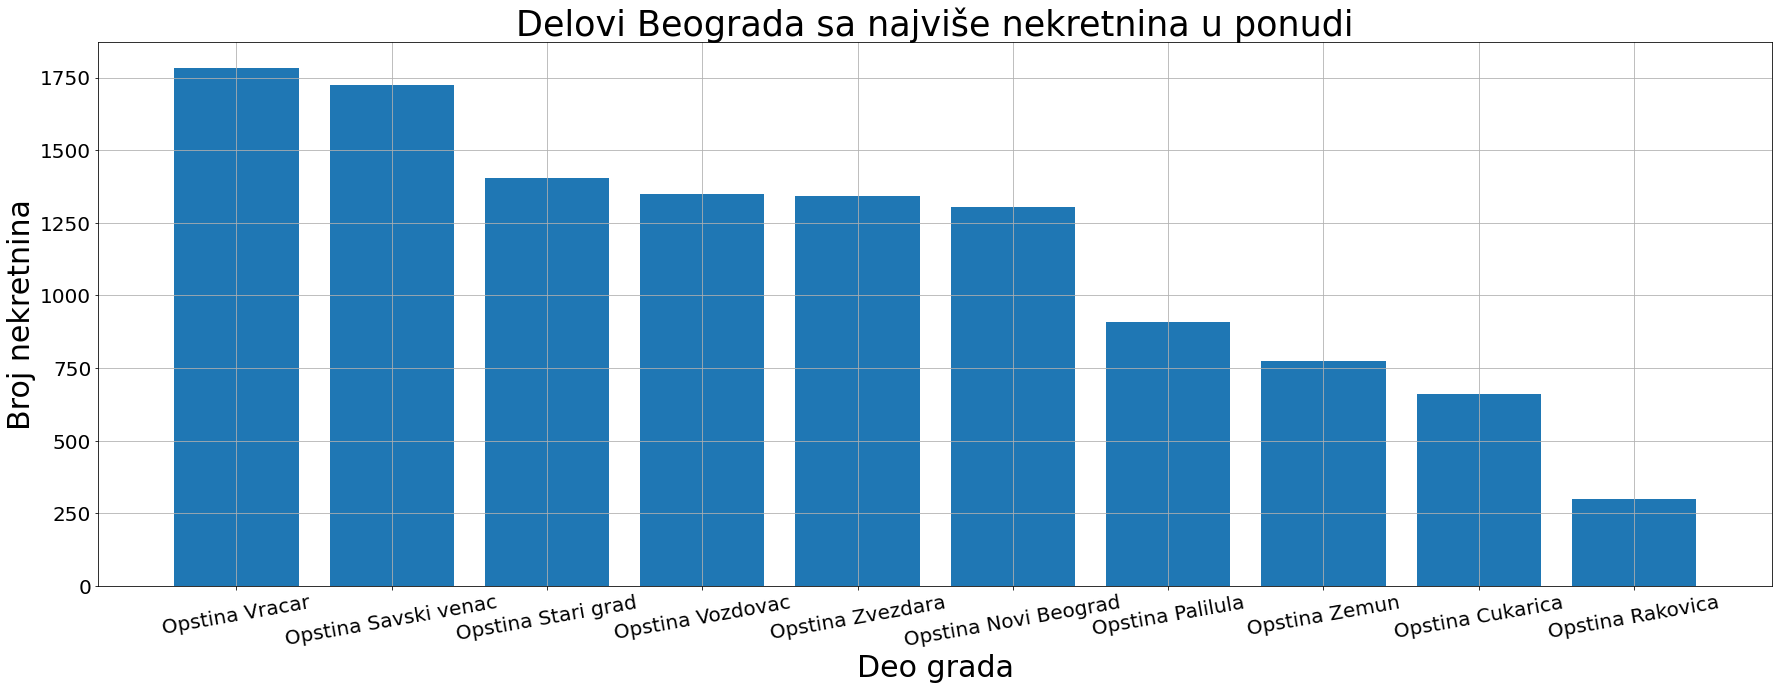

Second task
record gotten


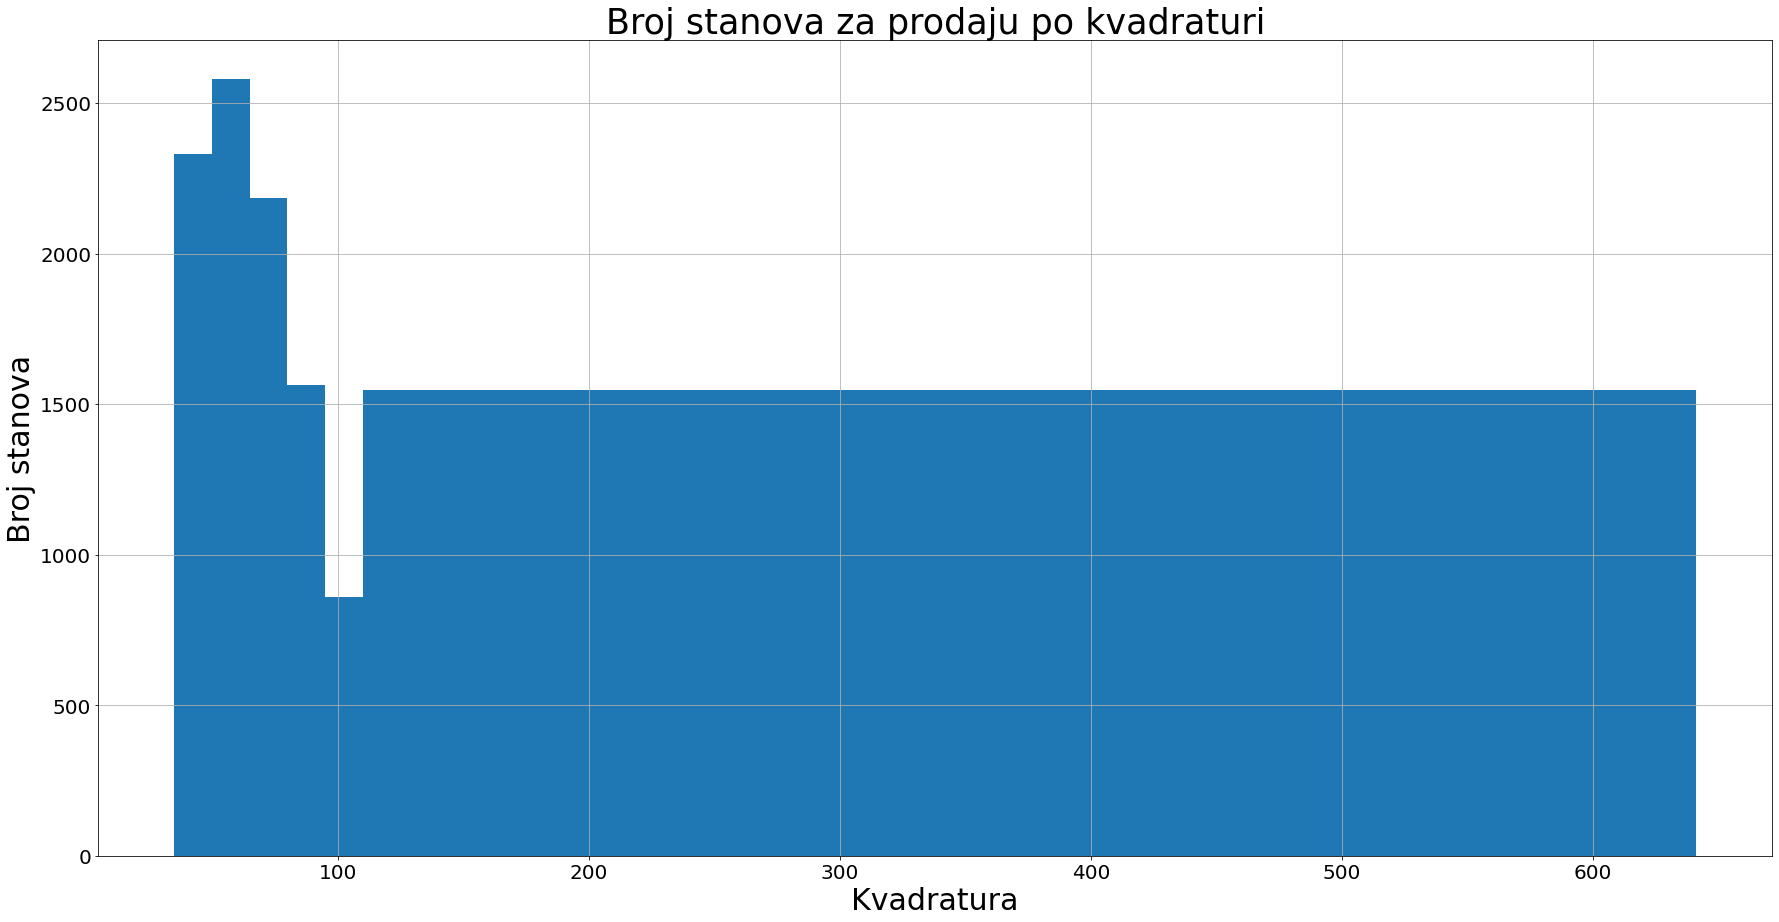

Third task
record gotten


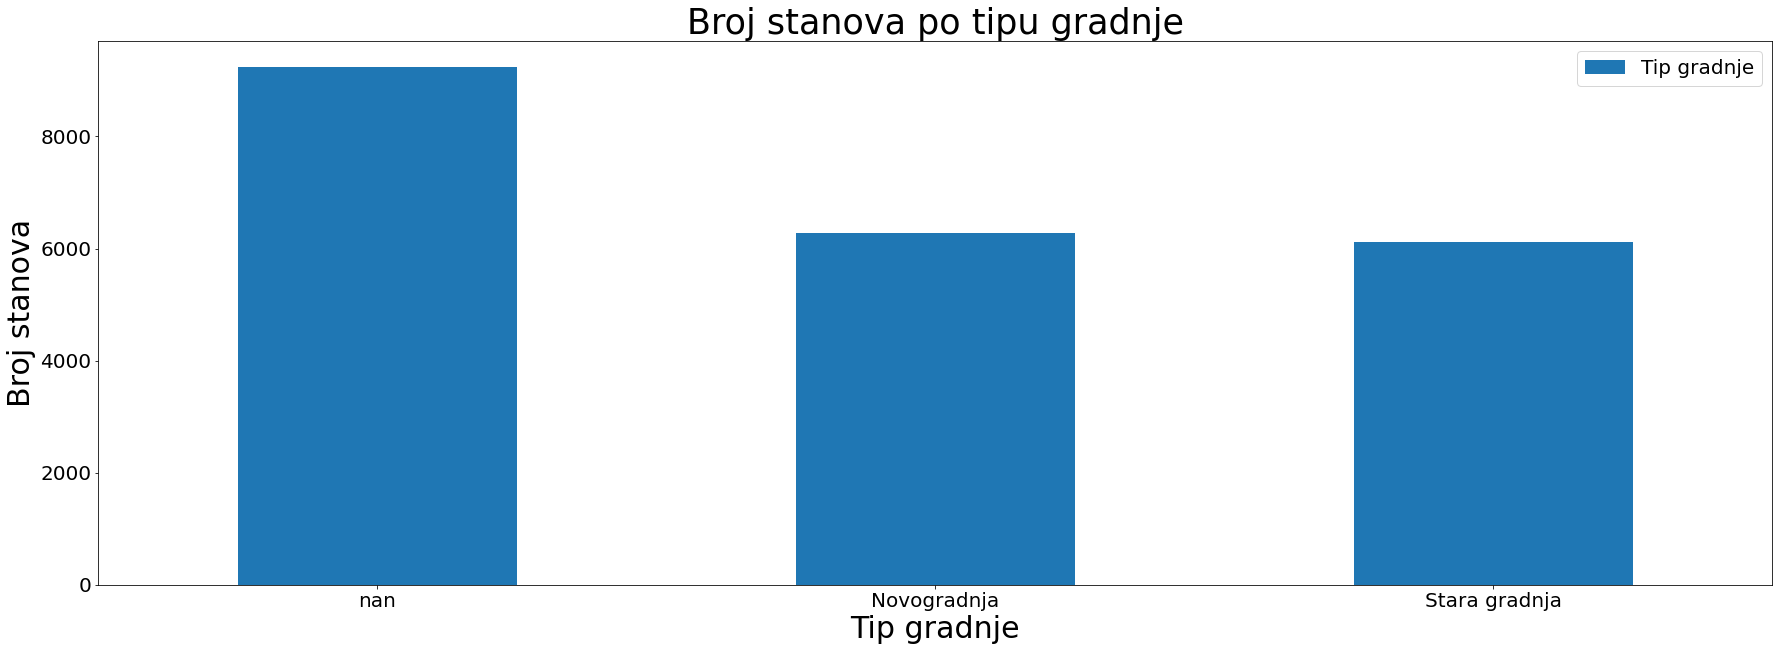

Fourth task
record gotten


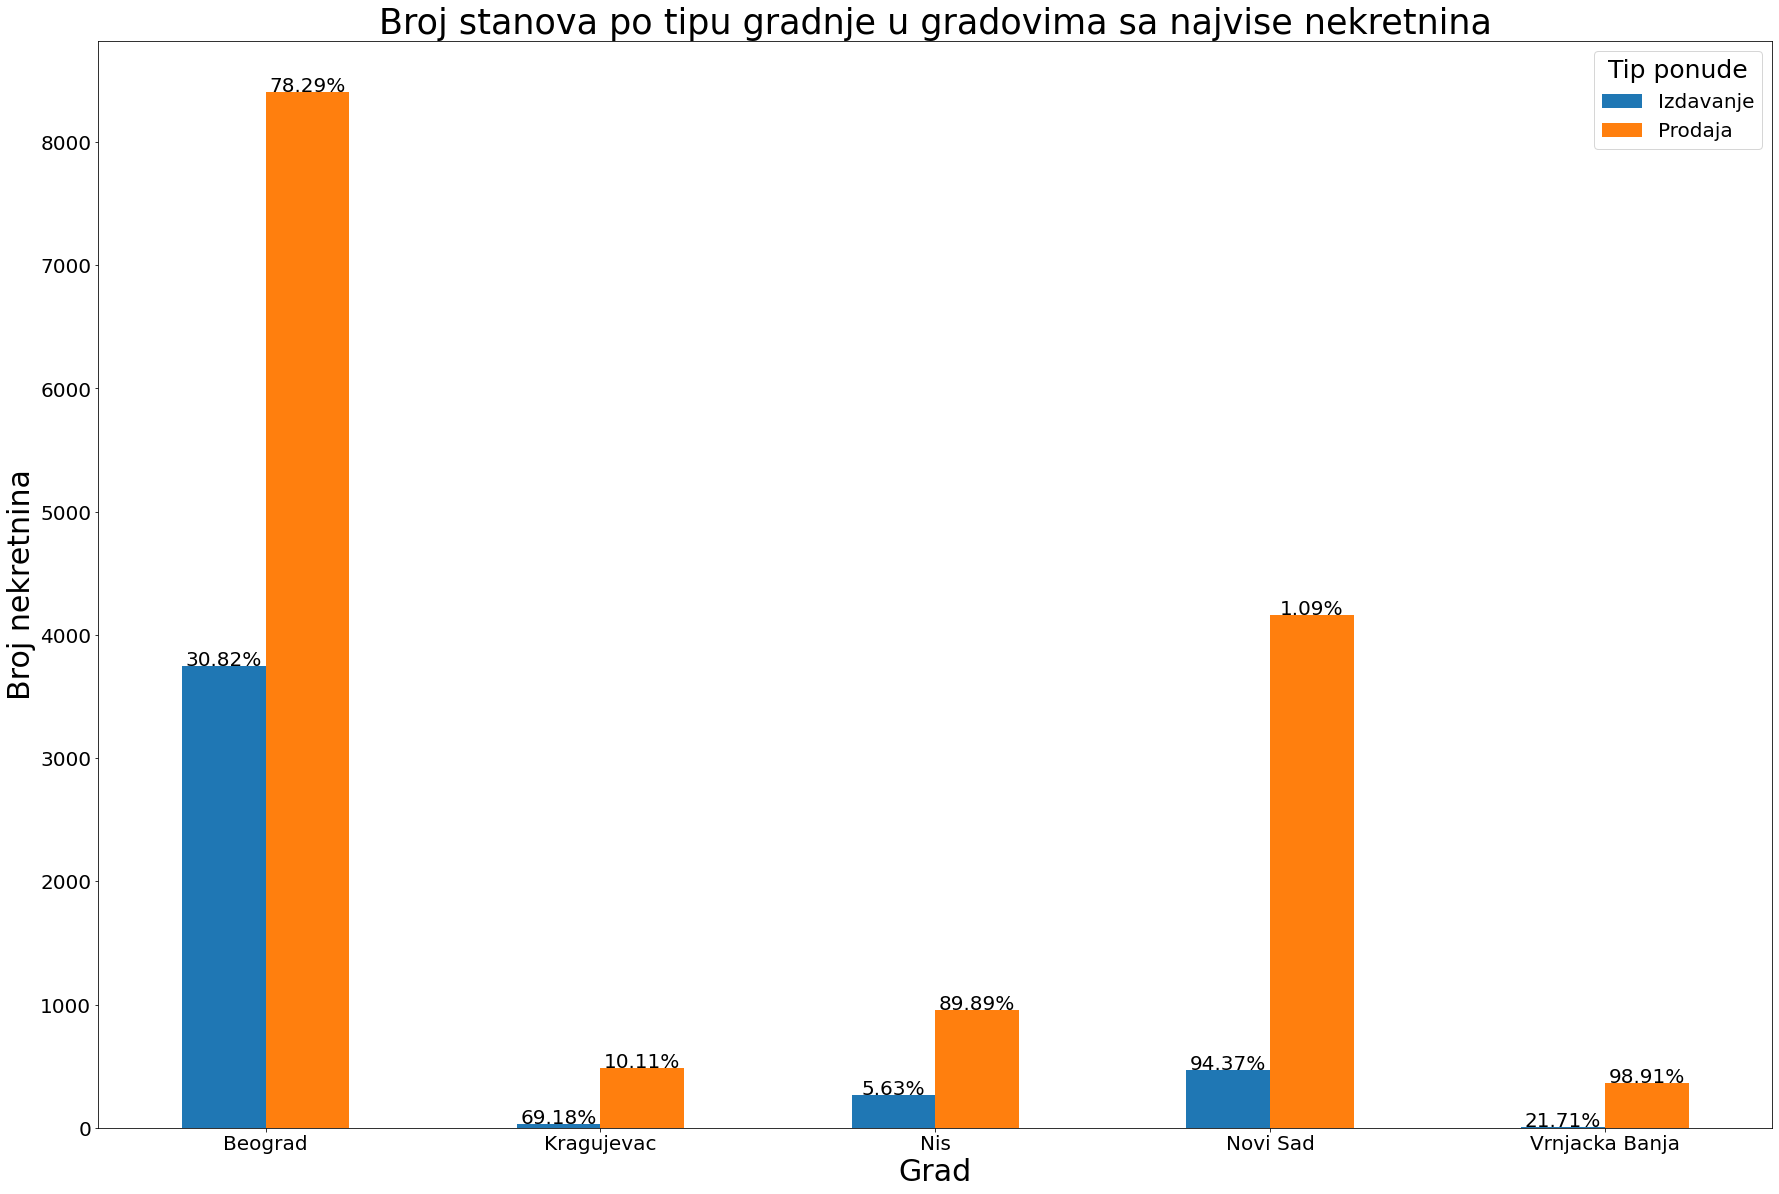

Fifth task
record gotten


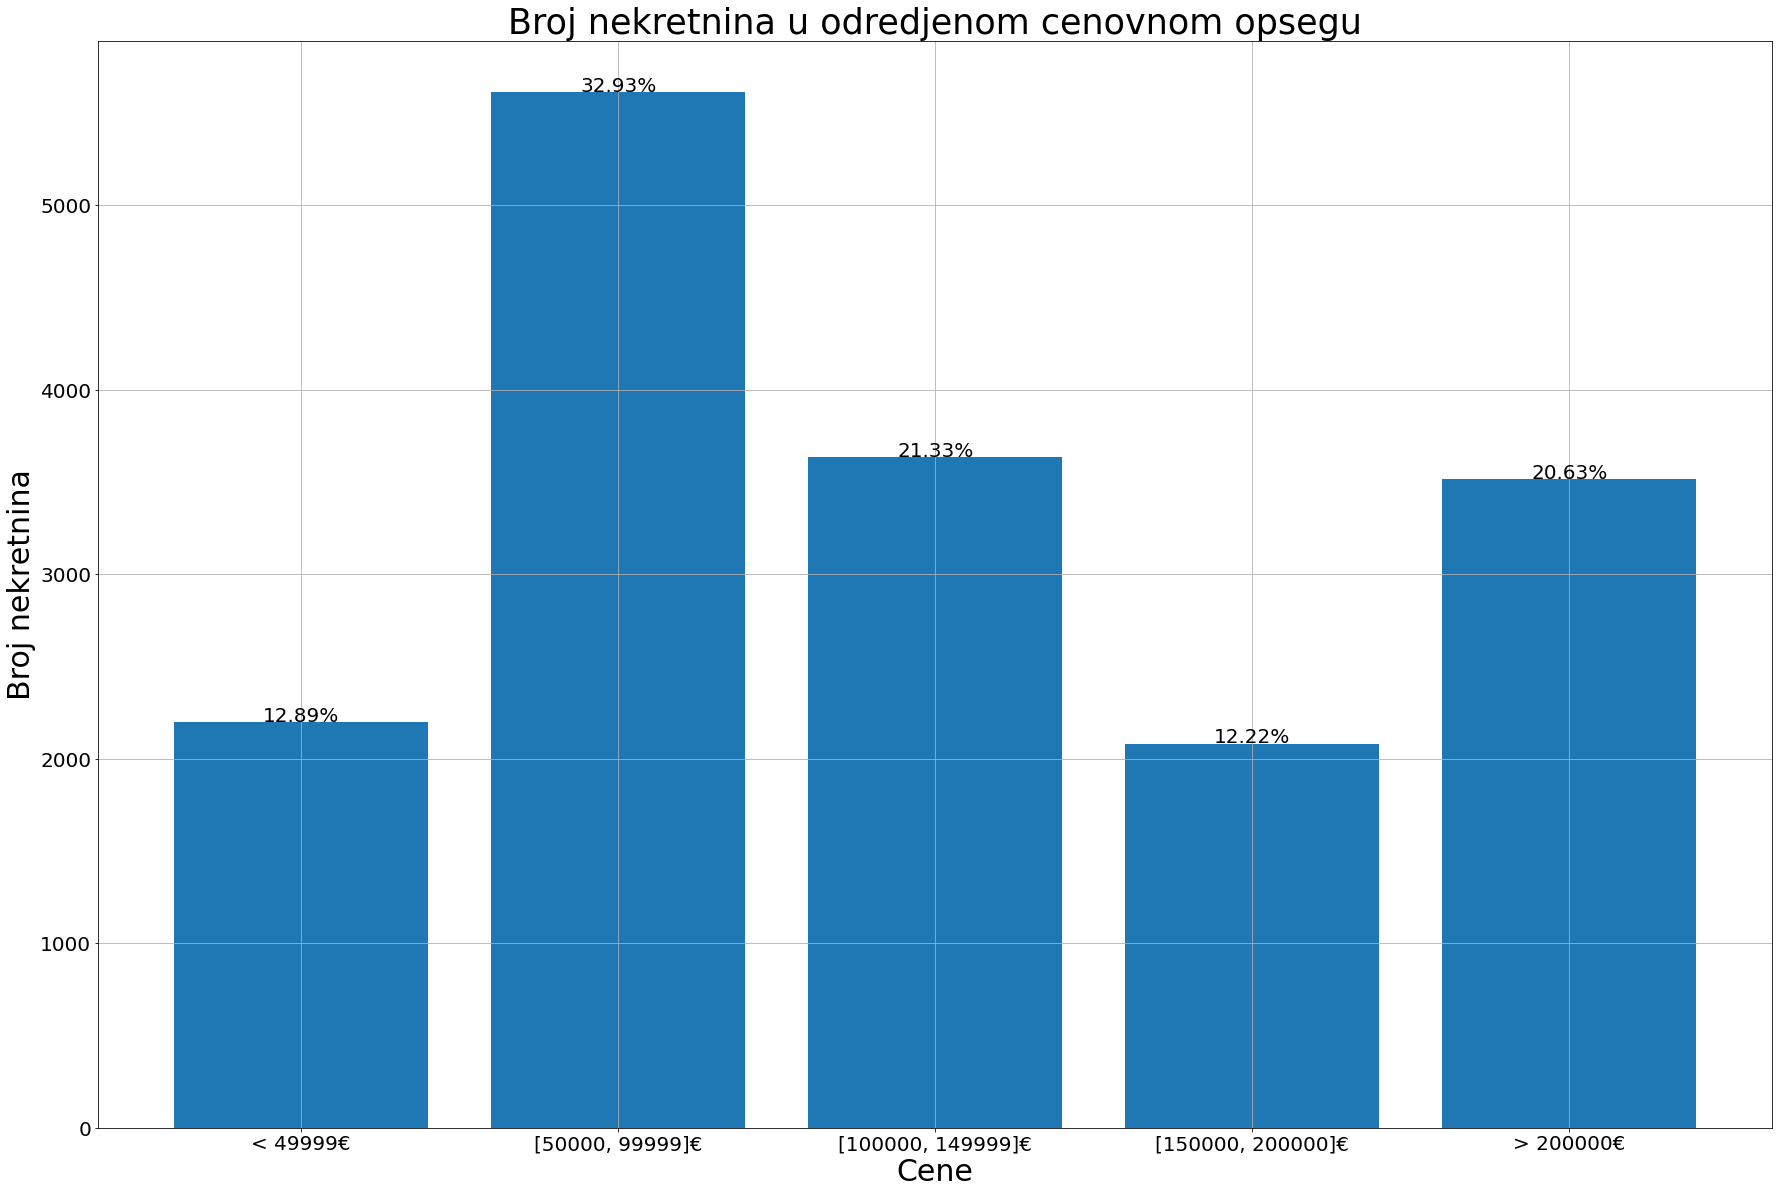

Sixth task
record gotten


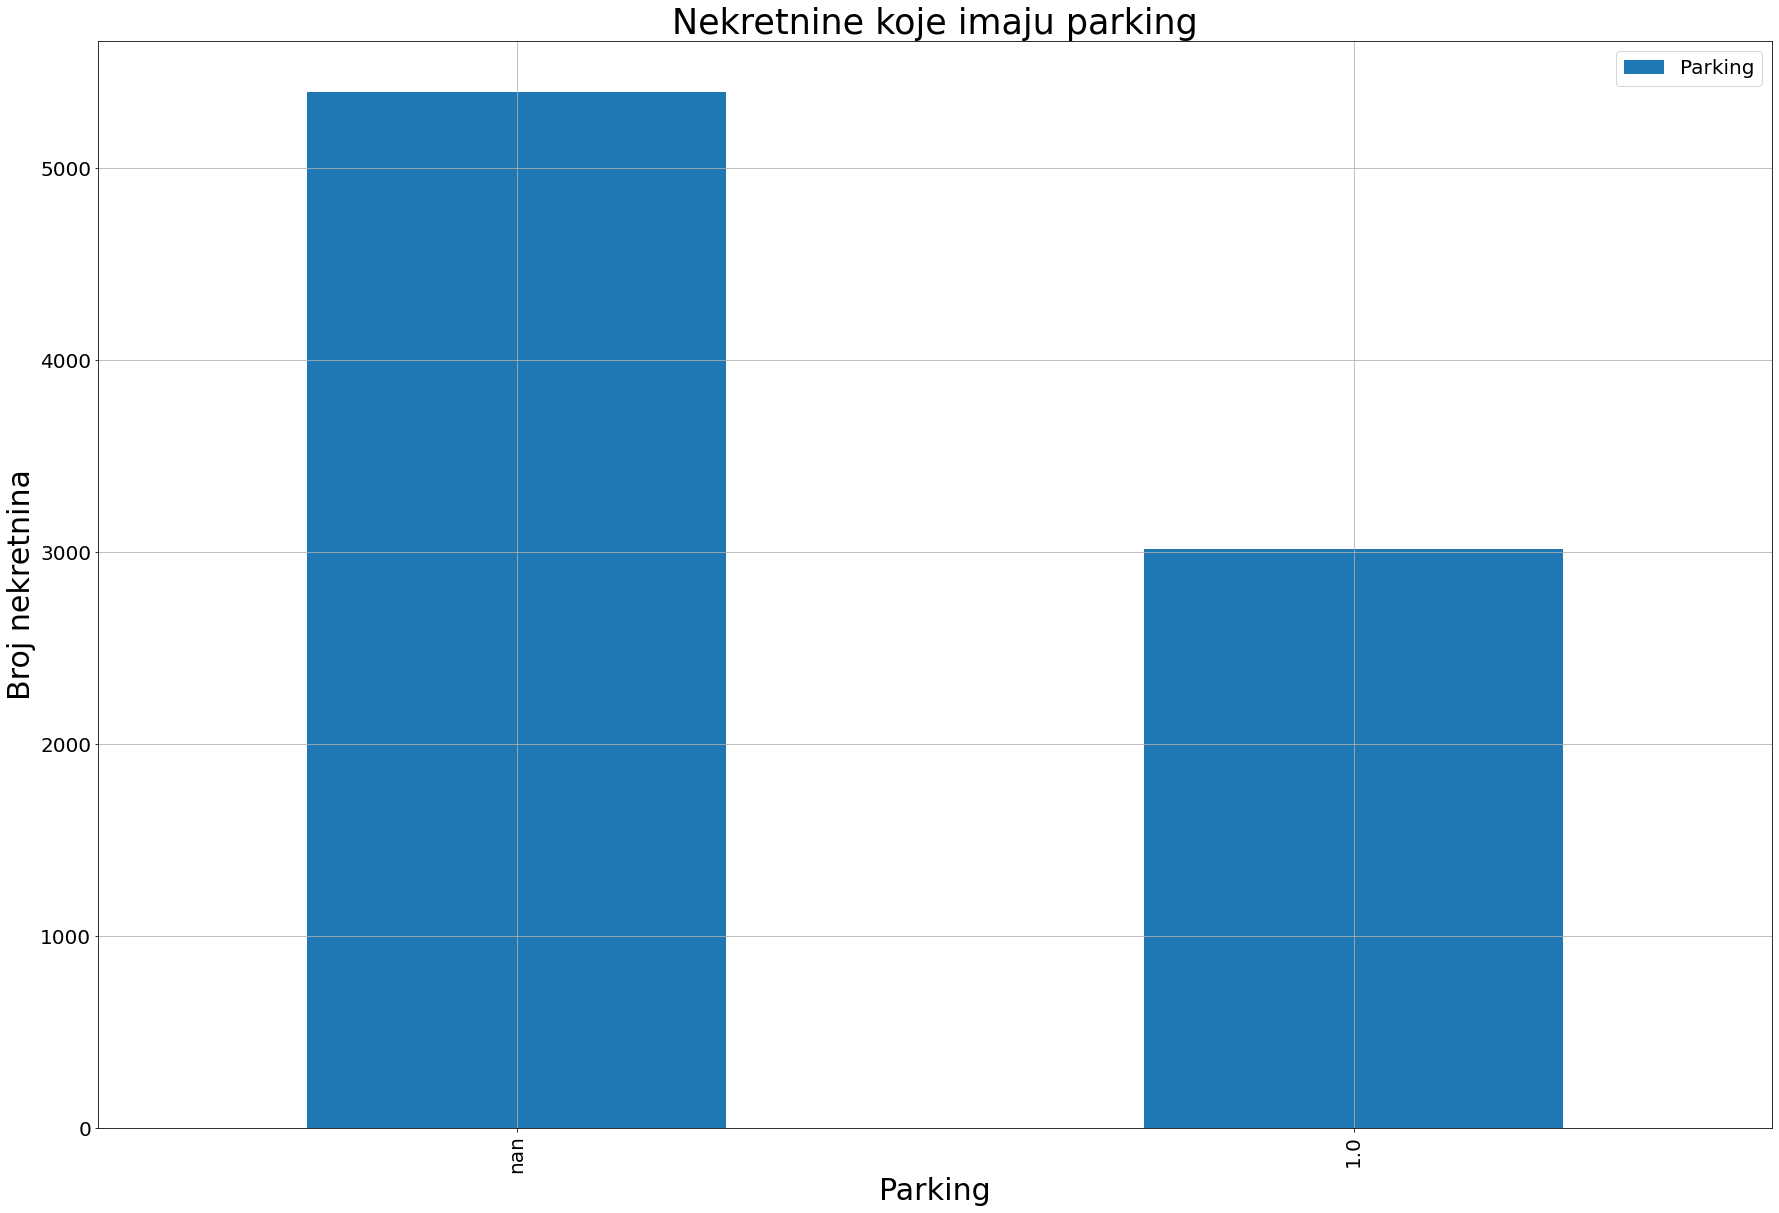

In [4]:
dataVisualiser =  DataVisualiser()
dataVisualiser.plotTasks()